<a href="https://colab.research.google.com/github/cliu-15/R250-Autoencoders-czl22/blob/master/AE_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project 2. PCA produces an ordered list of orthogonal latent variables. Compare approaches for achieving the same with autoencoders. 
Relevant papers:
*   A PCA-like autoencoder (https://arxiv.org/abs/1904.01277)
*   Learning Ordered Representations with Nested Dropout (https://arxiv.org/abs/1402.0915)
*   The β-VAE paper we studied





## Set-up

Read-in / Pre-process Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

import sys
sys.path.append('/content/drive/My Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import sklearn.decomposition

import IPython
from utils import interrupted, enumerate_cycle
from utils import mnist, mnist_batched
from intro_ae import SimpleAE
from pca_ae import PCA_AE


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


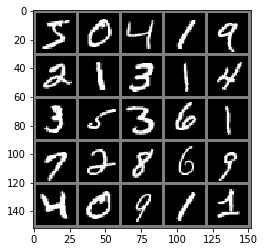

In [3]:
#example images from MNIST (first 5 batches)
iterate = iter(mnist_batched)
imgs1,_ = next(iterate)
imgs2,_ = next(iterate)
imgs3,_ = next(iterate)
imgs4,_ = next(iterate)
imgs5,_ = next(iterate)
img_recon = torch.cat([imgs1, imgs2, imgs3, imgs4, imgs5], 0)
x = torchvision.utils.make_grid(img_recon, nrow=5, pad_value=.5)

plt.imshow(x.numpy().transpose((1,2,0)))
plt.show()

## PCA with Raw Data

- PCA: finds set of orthogonal axes aligned with directions of greatest variability; via singular value decomposition of empirical covariance matrix of data

### PCA and Visualization

In [5]:
# convert MNIST dataset into numpy arrays
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))])
mnist_data = torchvision.datasets.MNIST(root = 'data/', download = True, train = True, transform = transform)
dataloader = torch.utils.data.DataLoader(mnist_data, batch_size=len(mnist_data))
data = next(iter(dataloader))[0].numpy()
data = np.reshape(data, (data.shape[0], data.shape[2] * data.shape[3]))
labels = next(iter(dataloader))[1].numpy()
print(data.shape)
print(labels.shape)

(60000, 784)
(60000,)


Original size:  (60000, 784)
Reduced PCA size:  (60000, 4)
Top 10 components:  [[-2.7733663e-10  1.4482125e-09  2.0692410e-09 ...  1.8960831e-09
   1.8960831e-09  1.8960831e-09]
 [ 7.3535333e-09  1.8520927e-09 -1.7349364e-09 ... -1.1314785e-09
  -1.1314785e-09 -1.1314785e-09]
 [ 2.0155605e-08 -1.5567782e-08 -1.9156943e-08 ... -5.4768196e-10
  -5.4768196e-10 -5.4768196e-10]
 [ 6.4630910e-08 -6.9932220e-09 -3.0249641e-08 ...  4.7501225e-09
   4.7501225e-09  4.7501225e-09]]
Variance explained:  [53.90399  39.413914 34.265877 29.935295]
Variance explained ratio:  [0.09704699 0.07095952 0.06169116 0.05389453]
0.28359220176935196


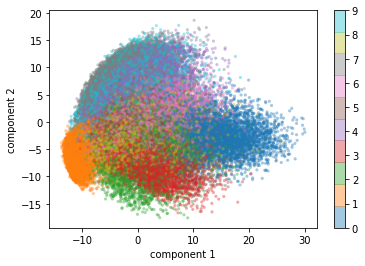

In [6]:
# perform PCA (10 dimensions) on raw input data
#X = np.stack(list(itertools.islice(data, 3000)))
#Y = np.stack(list(itertools.islice(labels, 3000)))
X = data
Y = labels
pca = sklearn.decomposition.PCA(n_components = 4)
pca_result = pca.fit_transform(X)
print("Original size: ", X.shape)
print("Reduced PCA size: ", pca_result.shape)
print("Top 10 components: ", pca.components_)
print("Variance explained: ", pca.explained_variance_)
print("Variance explained ratio: ", pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

# plot first 2 principal components
p1,p2 = pca_result[:,0], pca_result[:,1]
plt.scatter(p1, p2, c=Y, edgecolor='none', alpha=0.4, s=10, cmap=plt.cm.get_cmap('tab10', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.show()

### Reconstructions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


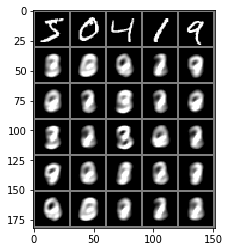

In [7]:
img_recon,_ = next(iter(mnist_batched))
img_recon = np.reshape(img_recon, (5, 1, 28, 28))
iterate = iter(mnist_batched)
for i in range(5):
  imgs,_ = next(iterate)
  flat_imgs= np.reshape(imgs, (5, 28 * 28))
  approx = pca.inverse_transform(pca.transform(flat_imgs))
  img_recon = torch.cat([img_recon, torch.from_numpy(approx.reshape(5, 1, 28, 28))], 0)
x = torchvision.utils.make_grid(img_recon, nrow=5, pad_value=.5)

plt.imshow(x.numpy().transpose((1,2,0)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


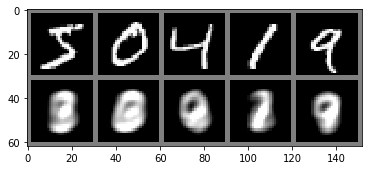

In [8]:
imgs,_ = next(iter(mnist_batched))
flat_imgs = np.reshape(imgs, (5, 28 * 28))
approx = pca.inverse_transform(pca.transform(flat_imgs))
img_recon = torch.cat([imgs, torch.from_numpy(approx.reshape(5, 1, 28, 28))], 0)
x = torchvision.utils.make_grid(img_recon, nrow=5, pad_value=.5)

plt.imshow(x.numpy().transpose((1,2,0)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


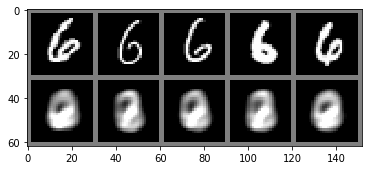

In [9]:
imgs = (img for img,lbl in mnist if lbl==6)
imgs = list(next(imgs) for _ in range(5))
imgs = torch.cat(imgs, 0).reshape((5,1,28,28))
flat_imgs = np.reshape(imgs, (5, 28 * 28))
approx = pca.inverse_transform(pca.transform(flat_imgs))
img_recon = torch.cat([imgs,torch.from_numpy(approx.reshape(5, 1, 28, 28))], 0)
x = torchvision.utils.make_grid(img_recon, nrow=5, pad_value=.5)

plt.imshow(x.numpy().transpose((1,2,0)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([28, 1, 28, 28])


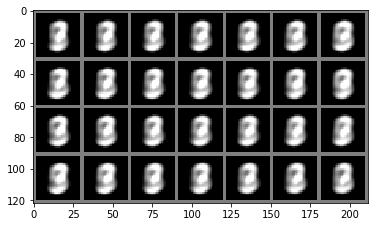

In [10]:
img0,_ = next(iter(mnist))
img = np.reshape(img0, (1, 28 * 28))
z = torch.from_numpy(pca.transform(img).transpose()).flatten()
i = torch.eye(4)
zvar = torch.stack([z + λ*i[d] for d in range(4) for λ in np.linspace(-1,1,7)])
rx = torch.reshape(torch.from_numpy(pca.inverse_transform(zvar)), (4*7, 1, 28, 28))
print(np.shape(rx))
rx = torchvision.utils.make_grid(rx, nrow=7, pad_value=.5)

plt.imshow(rx.numpy().transpose((1,2,0)))
plt.show()

## PCA with Vanilla Autoencoder (from intro demo)

### Loading/Training Autoencoder

copied from intro demo:

In [0]:
 # Load the pre-trained autoencoder
%cd /content/drive/My\ Drive
fit = SimpleAE(latent_dim=4)
fit.load_state_dict(torch.load('models/intro_ae_4d.pt'))

/content/drive/My Drive


<All keys matched successfully>

In [0]:
# Alternatively, train it yourself.

# Create a new model object, and initialize its parameters
fit = SimpleAE(latent_dim=8)

# Prepare to iterate through all the training data.
# See the note in utils.py
iter_training_data = enumerate_cycle(mnist_batched)

# You can interrupt part way through training (Kernel|Interrupt),
# then tweak e.g. the learning rate, then resume this cell.
optimizer = optim.Adadelta(fit.parameters(), lr=1)

while not interrupted():
    (epoch, batch_num), (imgs,lbls) = next(iter_training_data)
    optimizer.zero_grad()
    _,rx = fit(imgs)
    e = nn.functional.mse_loss(imgs, rx)
    e.backward()
    optimizer.step()

    if batch_num % 25 == 0:
        IPython.display.clear_output(wait=True)
        print(f'epoch={epoch} batch={batch_num}/{len(mnist_batched)} loss={e.item()}')

# Optionally, save all the parameters
torch.save(fit.state_dict(), 'intro_ae_8d.pt')

epoch=9 batch=7650/12000 loss=0.02479441836476326
Interrupt!


### PCA on latent variables (copied from intro demo):

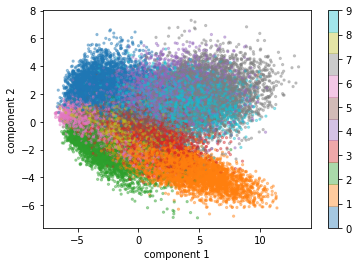

In [0]:
res = (fit(img.unsqueeze(0)) for img,_ in iter(mnist))
z = (z[0].detach().numpy() for z,rx in res)
X = np.stack(list(itertools.islice(z, 60000)))
lbl = [lbl for _,lbl in itertools.islice(mnist, 60000)]

pca = sklearn.decomposition.PCA()
pca_result = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
p1,p2 = pca_result[:,0], pca_result[:,1]

plt.scatter(p1, p2, c=lbl, cmap=plt.get_cmap('tab10', 10), alpha=.4, s=5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.show()

### Reconstructions

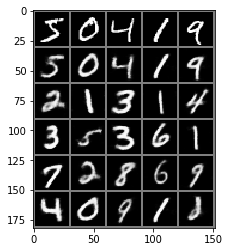

In [0]:
img_recon,_ = next(iter(mnist_batched))
iterate = iter(mnist_batched)
for i in range(5):
  imgs,_ = next(iterate)
  _,rx = fit(imgs)
  img_recon = torch.cat([img_recon, rx.detach()], 0)
x = torchvision.utils.make_grid(img_recon, nrow=5, pad_value=.5)

plt.imshow(x.numpy().transpose((1,2,0)))
plt.show()

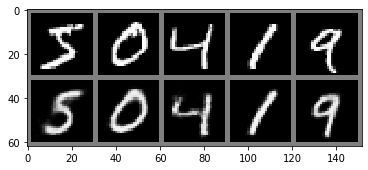

In [0]:
# Take the first batch of images, run them through the autoencoder,
# and display. NOTE: Torch builds up a computation graph, remembering
# all the operations you apply, so it can do backpropagation.
# If all you want to do is explore what it's done, use
#     x.detach().numpy()
# to get a numpy object, detached from the computation graph.

imgs,_ = next(iter(mnist_batched))
_,rx = fit(imgs)
img_recon = torch.cat([imgs,rx.detach()], 0)
x = torchvision.utils.make_grid(img_recon, nrow=5, pad_value=.5)

plt.imshow(x.numpy().transpose((1,2,0)))
plt.show()

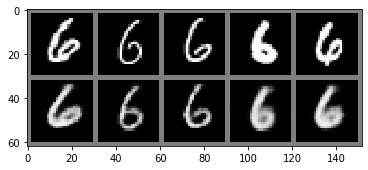

In [0]:
 # Pick out the first few instances of a digit 6, and compare their reconstructions.

imgs = (img for img,lbl in mnist if lbl==6)
imgs = list(next(imgs) for _ in range(5))
imgs = torch.cat(imgs, 0).reshape((5,1,28,28))
z,rx = fit(imgs)
img_recon = torch.cat([imgs,rx.detach()], 0)
x = torchvision.utils.make_grid(img_recon, nrow=5, pad_value=.5)

plt.imshow(x.numpy().transpose((1,2,0)))
plt.show()

### Varying Latent Dimensions

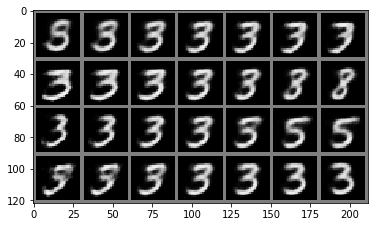

In [0]:
img0,_ = next(iter(mnist))
z,_ = fit(img0.unsqueeze(0))
z = z[0].detach()
i = torch.eye(4)
zvar = torch.stack([z + λ*i[d] for d in range(4) for λ in np.linspace(-1,1,7)])
rx = fit.decoder(zvar).detach()
rx = torchvision.utils.make_grid(rx, nrow=7, pad_value=.5)

plt.imshow(rx.numpy().transpose((1,2,0)))
plt.show()

## PCA-like Autoencoder (based on paper)

### Set-up

In [14]:
# Load the pre-trained autoencoders
%cd /content/drive/My\ Drive
from pca_ae import Reshaper, reconstruct
models = []
for i in range(1, 7):
  fit = PCA_AE(latent_dim = i)
  fit = torch.load('models/pca_ae_6d_'+str(i)+'.pt')
  models.append(fit)

/content/drive/My Drive


In [0]:
# Or train it yourself. UPDATE THIS

# max latent space size
d_max = 4
prev_z = []
models = []

for k in range(1, d_max + 1):
    iter_training_data = enumerate_cycle(mnist_batched)

    fit = PCA_AE(latent_dim=k)
    optimizer = optim.Adadelta(fit.parameters(), lr=1)

    #print("Press Ctrl+C to end training and save parameters")
    epoch = 0
    max_epochs = 5

    while epoch < max_epochs:
        (epoch, batch_num), (imgs, lbls) = next(iter_training_data)
        optimizer.zero_grad()

        # train for new dimension (passing in previous latent space)
        prev_z = torch.empty(np.shape(imgs)[0],0)
        for i in range(k-1):
            if k == 2:
                prev_z = models[i].encoder(imgs)
            else:
                prev_z = torch.cat((prev_z, models[i].encoder(imgs)), 1)
        z, rx = fit(imgs, prev_z)

        # add covariance term
        lam = 0.05
        cov = 0.0
        for i in range(k - 1):
            cov += np.dot(z[:, i].detach(), z[:, k - 1].detach())
        cov = cov / np.shape(z)[0]

        e = nn.functional.mse_loss(imgs, rx) + lam * cov
        e.backward(retain_graph = True)
        optimizer.step()

        if batch_num % 25 == 0:
            IPython.display.clear_output(wait=True)
            print(f'k={k} epoch={epoch} batch={batch_num}/{len(mnist_batched)} loss={e.item()}')

    # store current model
    models.append(fit)

    # save all models
    torch.save(fit, '/content/drive/My Drive/pca_ae_4d_'+str(k)+'.pt')

In [0]:
def reconstruct(imgs, models):
    z = torch.empty(np.shape(imgs)[0],0)
    for i in range(np.shape(models)[0]):
        z = torch.cat((z, models[i].encoder(imgs)), 1)
    rx = models[np.shape(models)[0] - 1].decoder(z)
    return z, rx

### PCA on latent variables

### Reconstructions

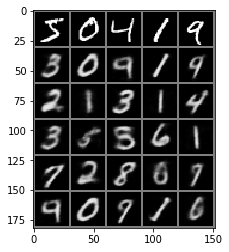

In [0]:
img_recon,_ = next(iter(mnist_batched))
iterate = iter(mnist_batched)
for i in range(5):
  imgs,_ = next(iterate)
  _,rx = reconstruct(imgs, models)
  img_recon = torch.cat([img_recon, rx.detach()], 0)
x = torchvision.utils.make_grid(img_recon, nrow=5, pad_value=.5)

plt.imshow(x.numpy().transpose((1,2,0)))
plt.show()

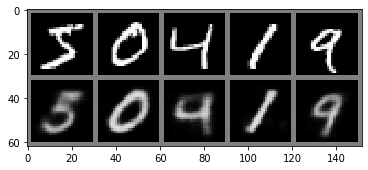

In [0]:
imgs,_ = next(iter(mnist_batched))
_,rx = reconstruct(imgs, models)
img_recon = torch.cat([imgs,rx.detach()], 0)
x = torchvision.utils.make_grid(img_recon, nrow=5, pad_value=.5)

plt.imshow(x.numpy().transpose((1,2,0)))
plt.show()

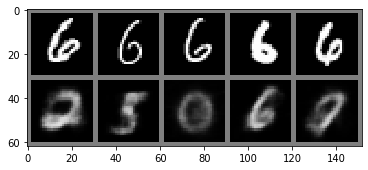

In [0]:
imgs = (img for img,lbl in mnist if lbl==6)
imgs = list(next(imgs) for _ in range(5))
imgs = torch.cat(imgs, 0).reshape((5,1,28,28))
z,rx = reconstruct(imgs, models)
img_recon = torch.cat([imgs,rx.detach()], 0)
x = torchvision.utils.make_grid(img_recon, nrow=5, pad_value=.5)

plt.imshow(x.numpy().transpose((1,2,0)))
plt.show()

### Varying Latent Dimensions

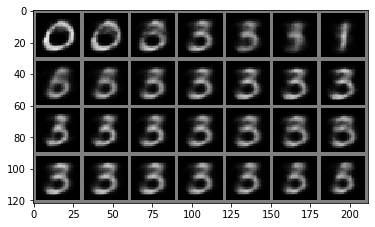

In [0]:
imgs,_ = next(iter(mnist_batched))
z,_ = reconstruct(imgs, models)
z = z[0].detach()
i = torch.eye(4)
zvar = torch.stack([z + λ*i[d] for d in range(4) for λ in np.linspace(-1,1,7)])
rx = models[np.shape(models)[0] - 1].decoder(zvar).detach()
rx = torchvision.utils.make_grid(rx, nrow=7, pad_value=.5)

plt.imshow(rx.numpy().transpose((1,2,0)))
plt.show()

## Nested dropout autoencoder (based on paper)

### Set-up

In [0]:
%cd /content/drive/My\ Drive
from nd_ae import ND_AE
fit = ND_AE(latent_dim=4)
fit.load_state_dict(torch.load('models/nd_ae_4d.pt'))

/content/drive/My Drive


<All keys matched successfully>

In [0]:
# Alternatively, train it yourself.

# Create a new model object, and initialize its parameters
fit = ND_AE(latent_dim=6)

# Prepare to iterate through all the training data.
# See the note in utils.py
iter_training_data = enumerate_cycle(mnist_batched)

optimizer = optim.Adadelta(fit.parameters(), lr=1)

while not interrupted():
    (epoch, batch_num), (imgs,lbls) = next(iter_training_data)
    optimizer.zero_grad()
    _,rx = fit(imgs)
    e = nn.functional.mse_loss(imgs, rx)
    e.backward()
    optimizer.step()

    if batch_num % 25 == 0:
        IPython.display.clear_output(wait=True)
        print(f'epoch={epoch} batch={batch_num}/{len(mnist_batched)} loss={e.item()}')

# Optionally, save all the parameters
torch.save(fit.state_dict(), '/content/drive/My Drive/nd_ae_6d.pt')

epoch=10 batch=3050/12000 loss=0.053729098290205
Interrupt!


### Reconstructions

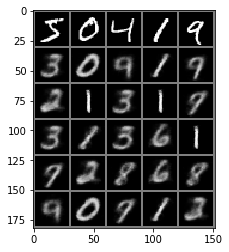

In [0]:
img_recon,_ = next(iter(mnist_batched))
iterate = iter(mnist_batched)
for i in range(5):
  imgs,_ = next(iterate)
  _,rx = fit(imgs)
  img_recon = torch.cat([img_recon, rx.detach()], 0)
x = torchvision.utils.make_grid(img_recon, nrow=5, pad_value=.5)

plt.imshow(x.numpy().transpose((1,2,0)))
plt.show()

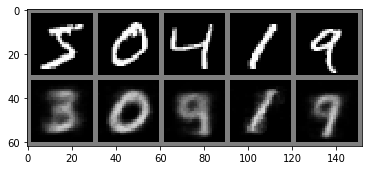

In [0]:
imgs,_ = next(iter(mnist_batched))
z,rx = fit(imgs)
img_recon = torch.cat([imgs,rx.detach()], 0)
x = torchvision.utils.make_grid(img_recon, nrow=5, pad_value=.5)

plt.imshow(x.numpy().transpose((1,2,0)))
plt.show()

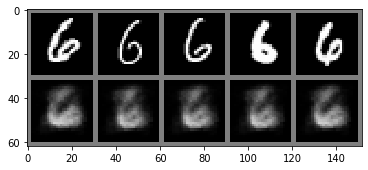

In [0]:
imgs = (img for img,lbl in mnist if lbl==6)
imgs = list(next(imgs) for _ in range(5))
imgs = torch.cat(imgs, 0).reshape((5,1,28,28))
z,rx = fit(imgs)
img_recon = torch.cat([imgs,rx.detach()], 0)
x = torchvision.utils.make_grid(img_recon, nrow=5, pad_value=.5)

plt.imshow(x.numpy().transpose((1,2,0)))
plt.show()

### Varying Latent Dimensions

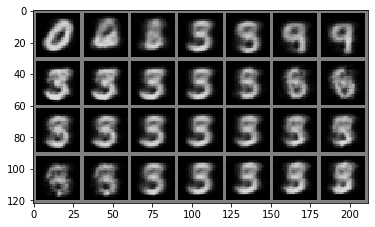

In [0]:
img0,_ = next(iter(mnist))
z,_ = fit(img0.unsqueeze(0))
z = z[0].detach()
i = torch.eye(4)
zvar = torch.stack([z + λ*i[d] for d in range(4) for λ in np.linspace(-1,1,7)])
rx = fit.decoder(zvar).detach()
rx = torchvision.utils.make_grid(rx, nrow=7, pad_value=.5)

plt.imshow(rx.numpy().transpose((1,2,0)))
plt.show()

## B-VAE (based on paper)

Set-up (adapted from Andrei's code)

In [0]:
#%cd /content/drive/My\ Drive
from b_vae import B_VAE
fit = B_VAE(latent_dim=4)
fit.load_state_dict(torch.load('models/b_vae_4d.pt'))

<All keys matched successfully>

In [0]:
# Alternatively, train it yourself.

# Create a new model object, and initialize its parameters
fit = B_VAE(latent_dim=8)

# Prepare to iterate through all the training data.
# See the note at the top, under Utilities.
iter_training_data = enumerate_cycle(mnist_batched)

optimizer = optim.Adadelta(fit.parameters(), lr=0.05)

print("Press Ctrl+C to end training and save parameters")

beta = 3

while not interrupted():
    (epoch, batch_num), (imgs, lbls) = next(iter_training_data)
    optimizer.zero_grad()
    rx,mu,logvar,z = fit(imgs)
    e = B_VAE.loss_function(rx, imgs, mu, logvar, beta=beta)
    e.backward()
    optimizer.step()

    if batch_num % 25 == 0:
        IPython.display.clear_output(wait=True)
        print(f'epoch={epoch} batch={batch_num}/{len(mnist_batched)} loss={e.item()}')

# Optionally, save all the parameters
torch.save(fit.state_dict(), '/content/drive/My Drive/b_vae_8d.pt')

epoch=9 batch=4125/12000 loss=705.047119140625
Interrupt!


Reconstructions

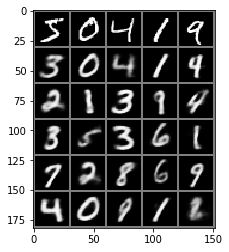

In [0]:
img_recon,_ = next(iter(mnist_batched))
iterate = iter(mnist_batched)
for i in range(5):
  imgs,_ = next(iterate)
  rx,mu,logvar,z = fit(imgs)
  img_recon = torch.cat([img_recon, rx.detach()], 0)
x = torchvision.utils.make_grid(img_recon, nrow=5, pad_value=.5)

plt.imshow(x.numpy().transpose((1,2,0)))
plt.show()

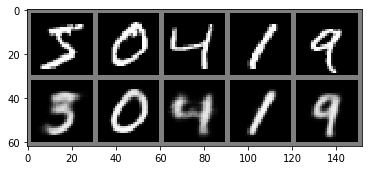

In [0]:
imgs,_ = next(iter(mnist_batched))
rx,mu,logvar,z = fit(imgs)
img_recon = torch.cat([imgs,rx.detach()], 0)
x = torchvision.utils.make_grid(img_recon, nrow=5, pad_value=.5)

plt.imshow(x.numpy().transpose((1,2,0)))
plt.show()

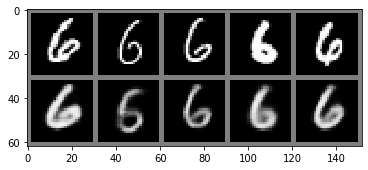

In [0]:
imgs = (img for img,lbl in mnist if lbl==6)
imgs = list(next(imgs) for _ in range(5))
imgs = torch.cat(imgs, 0).reshape((5,1,28,28))
rx,mu,logvar,z = fit(imgs)
img_recon = torch.cat([imgs,rx.detach()], 0)
x = torchvision.utils.make_grid(img_recon, nrow=5, pad_value=.5)

plt.imshow(x.numpy().transpose((1,2,0)))
plt.show()

### Varying Latent Dimensions

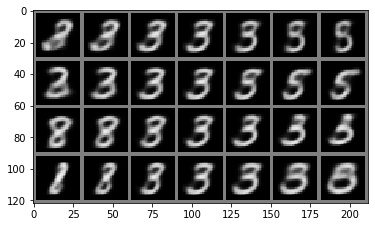

In [0]:
img0,_ = next(iter(mnist))
rx,mu,logvar,z = fit(img0.unsqueeze(0))
z = z[0].detach()
i = torch.eye(4)
zvar = torch.stack([z + λ*i[d] for d in range(4) for λ in np.linspace(-1,1,7)])
rx = fit.decoder(zvar).detach()
rx = torchvision.utils.make_grid(rx, nrow=7, pad_value=.5)

plt.imshow(rx.numpy().transpose((1,2,0)))
plt.show()